<a href="https://colab.research.google.com/github/ProvenDruid/CNNs/blob/main/cnn_VHLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
nGauss  = 2000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if i<1000:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [ ]:
labels = torch.zeros(2000,1)
labels[1000:]=1

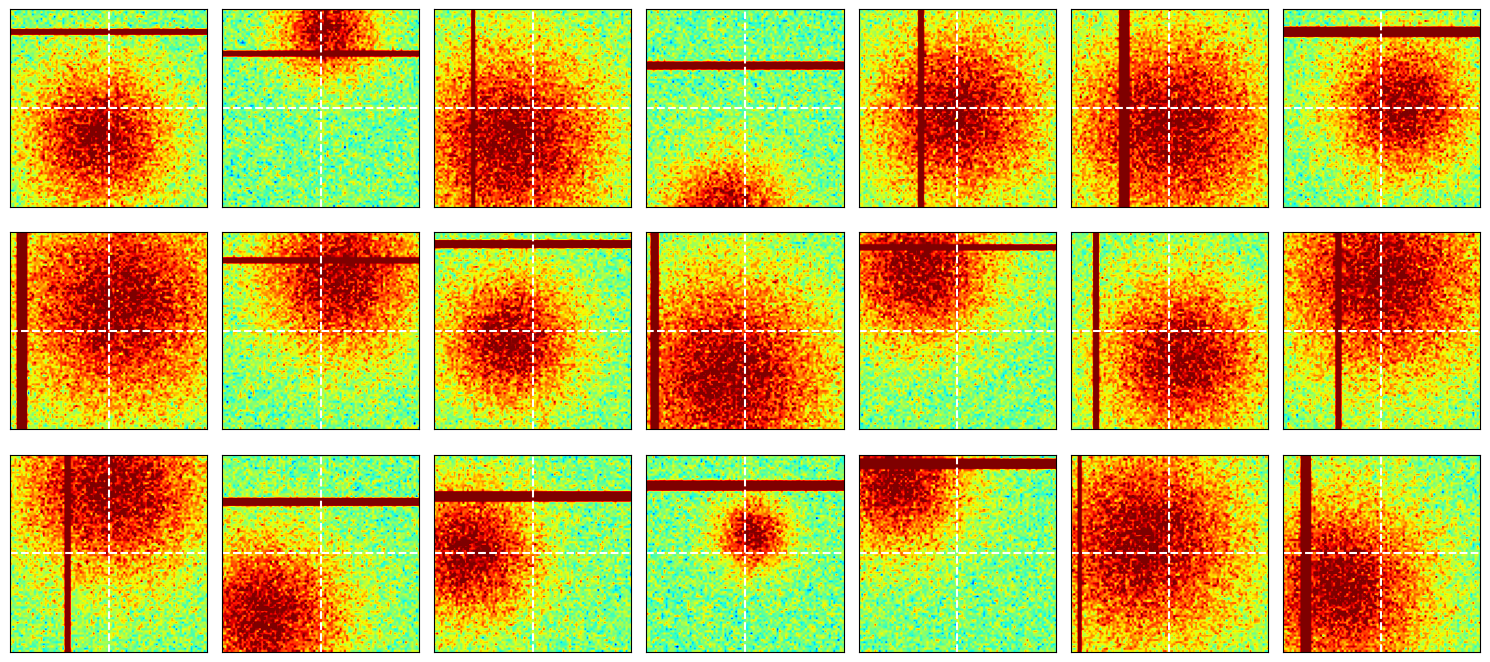

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 20
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifarnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,32,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: 91/2 = 45 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(32,64,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: 45/2 = 22 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(22*22*64,64)
      self.fc2 = nn.Linear(64,1)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')#91/2=45

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')#45/2=22

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cifarnet(printtoggle)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(dev_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [200, 1, 91, 91]
First CPR block: [200, 32, 45, 45]
Second CPR block: [200, 64, 22, 22]
Third CPR block: [200, 30976]
Final output: [200, 1]

Output size:
torch.Size([200, 1])
 
Loss:
tensor(0.6809, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### test performance
    net.eval()
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [ ]:
# ~3 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

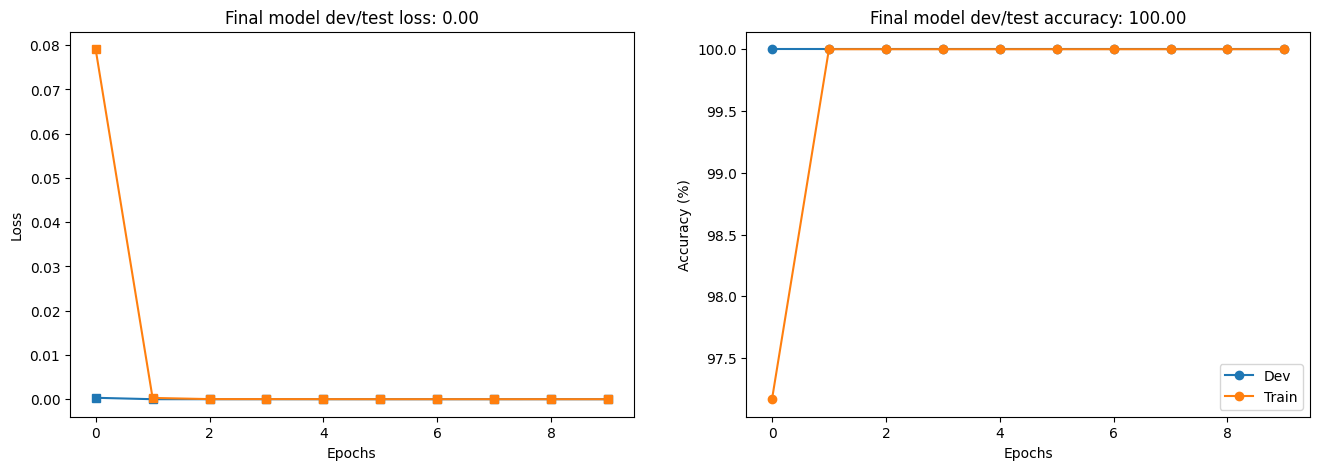

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(devLoss,'s-',label='Train')
ax[0].plot(trainLoss,'s-',label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Final model dev/test loss: {devLoss[-1]:.2f}')


ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(trainAcc,'o-',label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}')
ax[1].legend()

plt.show()

In [ ]:
net.eval() # switch to test mode
X,y = next(iter(dev_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

In [ ]:
yHat

tensor([[ 29.3990],
        [-28.0711],
        [ 19.2161],
        [ 14.8325],
        [ 14.3199],
        [ 26.9804],
        [ 18.8572],
        [-37.5675],
        [-16.5740],
        [ 28.9910],
        [-39.9727],
        [-13.8791],
        [ 19.1497],
        [ 27.8520],
        [ 15.9226],
        [ 14.8005],
        [-43.9495],
        [ 16.0617],
        [-28.9564],
        [ 26.7412],
        [-27.8791],
        [-28.8700],
        [ 13.4960],
        [-23.2062],
        [-26.2104],
        [ 16.3728],
        [ 15.9307],
        [ 13.4176],
        [-43.6396],
        [-26.1206],
        [-11.7269],
        [ 18.8650],
        [-27.9937],
        [-41.7180],
        [-22.3486],
        [ 19.4222],
        [-33.1954],
        [-18.7663],
        [-41.0765],
        [ 15.2689],
        [-21.3037],
        [-24.6523],
        [-32.7890],
        [ 20.0064],
        [ 16.1506],
        [-37.4887],
        [ 25.7473],
        [ 15.0601],
        [ 13.5460],
        [ 16.3031],


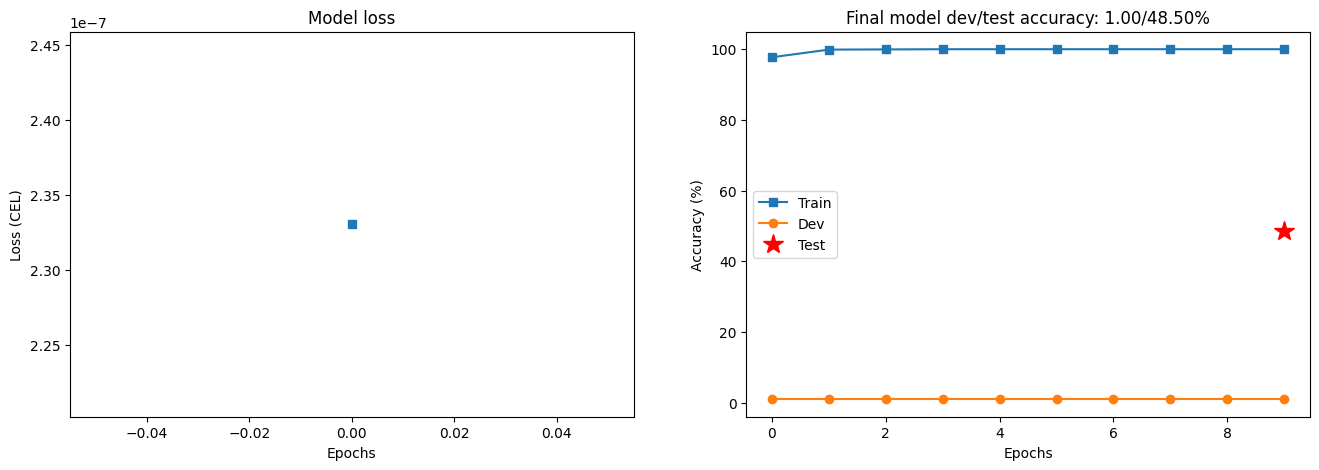

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(testLoss,'s-',label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()